КЛАССИФИКАЦИЯ: Представляет ли опасность Околоземный Объект?

*Иван Щербаков | OTUS ML BASIC*

# СБОРКА СОБСТВЕННОГО DATASET: NASA Open API

Я сразу не захотел брать готовый dataset, решил попробовать собрать самому.

Я встретил [NASA Open API](https://api.nasa.gov) по Околоземным Объектам.
Изучил его, получил API Key и начал смотреть на данные.
Встретил похожий [dataset](https://https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects/) на Kaggle, но решил все равно собрать свой и превзойти уже существующий.

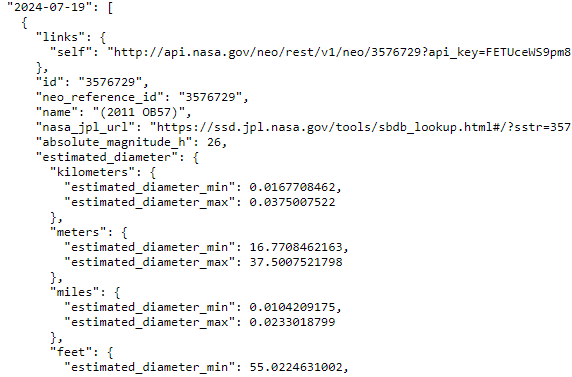

Это API от NASA предоставляет записи о Околоземных Объектах.
Записи можно брать с размахом в 7 дней.
Ну так как на 7 днях dataset не построишь - пришлось брать несколько раз по 7, а потом складывать в один dataset.

In [ ]:
import numpy as np
import math

import pandas as pd

import requests
import datetime
from tqdm.notebook import tqdm
from google.colab import files, userdata
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
API_KEY = userdata.get('NASA_TOKEN')

START_DATE = datetime.date(1910, 1, 1)

END_DATE = datetime.date(2024, 7, 14)

URL = f"https://api.nasa.gov/neo/rest/v1/feed"

In [ ]:
def fetch_neo_data(url):
    while True:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()

Для скорости: сначала соберем ссылки, а потом будем кидать запросы.

In [ ]:
delta_days = (END_DATE - START_DATE).days
current_start_date = START_DATE

requests_list = []

while current_start_date < END_DATE:
    current_end_date = current_start_date + datetime.timedelta(days=7)
    if current_end_date > END_DATE:
        current_end_date = END_DATE

    url = f"{URL}?start_date={current_start_date}&end_date={current_end_date}&api_key={API_KEY}"
    requests_list.append(url)

    current_start_date = current_end_date + datetime.timedelta(days=1)

print("Ссылки укомплектованы.")

Ссылки укомплектованы.


In [ ]:
len(requests_list)

5230

In [ ]:
requests_list[:5]

['https://api.nasa.gov/neo/rest/v1/feed?start_date=1910-01-01&end_date=1910-01-08&api_key=FETUceWS9pm8kdchpEJAeDv2JwMCnkxRkwqqdjQM',
 'https://api.nasa.gov/neo/rest/v1/feed?start_date=1910-01-09&end_date=1910-01-16&api_key=FETUceWS9pm8kdchpEJAeDv2JwMCnkxRkwqqdjQM',
 'https://api.nasa.gov/neo/rest/v1/feed?start_date=1910-01-17&end_date=1910-01-24&api_key=FETUceWS9pm8kdchpEJAeDv2JwMCnkxRkwqqdjQM',
 'https://api.nasa.gov/neo/rest/v1/feed?start_date=1910-01-25&end_date=1910-02-01&api_key=FETUceWS9pm8kdchpEJAeDv2JwMCnkxRkwqqdjQM',
 'https://api.nasa.gov/neo/rest/v1/feed?start_date=1910-02-02&end_date=1910-02-09&api_key=FETUceWS9pm8kdchpEJAeDv2JwMCnkxRkwqqdjQM']

In [ ]:
num_threads = 10
all_data = []

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = {executor.submit(fetch_neo_data, url): url for url in requests_list}

    for future in tqdm(as_completed(futures), total=len(futures)):
        data = future.result()
        if data:
            all_data.append(data)

In [ ]:
df_records = []
for data in all_data:
    for date in data['near_earth_objects']:
        for obj in data['near_earth_objects'][date]:
            df_records.append(obj)

df_original = pd.DataFrame(df_records)

In [ ]:
df = df_original.copy()

In [ ]:
df.shape[0]

338199

Всего получилось **338 199** записей! (собиралось ~3.5 часа)

In [ ]:
df.head()

,links,id,neo_reference_id,name,nasa_jpl_url,absolute_magnitude_h,estimated_diameter,is_potentially_hazardous_asteroid,close_approach_data,is_sentry_object,sentry_data
0,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,2162117,2162117,162117 (1998 SD15),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,19.14,{'kilometers': {'estimated_diameter_min': 0.39...,False,"[{'close_approach_date': '1910-01-31', 'close_...",False,NaN
1,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,2349507,2349507,349507 (2008 QY),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,18.50,{'kilometers': {'estimated_diameter_min': 0.53...,True,"[{'close_approach_date': '1910-01-31', 'close_...",False,NaN
2,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,2455415,2455415,455415 (2003 GA),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,21.45,{'kilometers': {'estimated_diameter_min': 0.13...,False,"[{'close_approach_date': '1910-01-31', 'close_...",False,NaN
3,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,3132126,3132126,(2002 PB),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,20.63,{'kilometers': {'estimated_diameter_min': 0.19...,False,"[{'close_approach_date': '1910-01-31', 'close_...",False,NaN
4,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,3557844,3557844,(2011 DW),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,22.70,{'kilometers': {'estimated_diameter_min': 0.07...,False,"[{'close_approach_date': '1910-01-31', 'close_...",False,NaN


Выглядело все так.⬆

In [ ]:
df.drop(["links",
         "id",
         "is_sentry_object",
         "nasa_jpl_url",
         "sentry_data"],
        axis=1,
        inplace=True) # мусор выкидываем

В `estimated_diameter` и `close_approach_data` запрятаны еще признаки - излечем их и добавим в dataset.

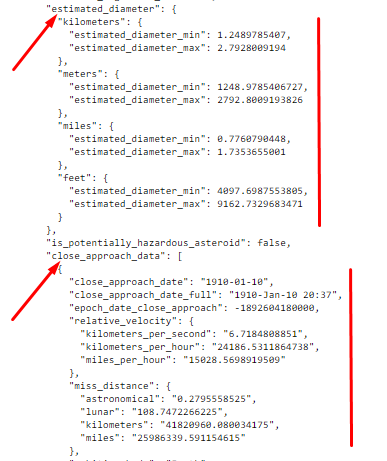

In [ ]:
estimated_diameter_df = pd.json_normalize(df['estimated_diameter']).iloc[:, :2]
df = pd.concat(
    [df, estimated_diameter_df],
    axis=1).drop('estimated_diameter', axis=1)

close_approach_data_df = pd.json_normalize(df['close_approach_data'])
close_approach_data_df = pd.json_normalize(close_approach_data_df.iloc[:, 0]).iloc[:, [3, 5, 9]]
df = pd.concat(
    [df, close_approach_data_df],
    axis=1).drop('close_approach_data', axis=1)

df.head(3)

,neo_reference_id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,kilometers.estimated_diameter_min,kilometers.estimated_diameter_max,orbiting_body,relative_velocity.kilometers_per_hour,miss_distance.kilometers
0,2162117,162117 (1998 SD15),19.14,False,0.394962,0.883161,Earth,71745.4010476829,58143623.319169725
1,2349507,349507 (2008 QY),18.50,True,0.530341,1.185878,Earth,109949.7571484926,55801047.818199438
2,2455415,455415 (2003 GA),21.45,False,0.136319,0.304818,Earth,24865.5067981164,67206887.722544621


Дальше просто улучшаем вид dataset.

In [ ]:
columns = list(df.columns)
columns.append(columns.pop(columns.index('is_potentially_hazardous_asteroid')))
df = df[columns]

df.rename(columns={'neo_reference_id': 'neo_id',
                   'absolute_magnitude_h': 'absolute_magnitude',
                   'kilometers.estimated_diameter_min': 'estimated_diameter_min',
                   'kilometers.estimated_diameter_max': 'estimated_diameter_max',
                   'relative_velocity.kilometers_per_hour': 'relative_velocity',
                   'miss_distance.kilometers': 'miss_distance',
                   'is_potentially_hazardous_asteroid': 'is_hazardous',},
                   inplace=True)

In [ ]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.4010476829,58143623.319169725,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.7571484926,55801047.818199438,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.5067981164,67206887.722544621,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.0768053243,30396444.123281813,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.5194835328,63118626.507265413,False


In [ ]:
df.to_csv('nearest-earth-objects(1910-2024).csv', index=False)
files.download('nearest-earth-objects(1910-2024).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Сохраняем!

[Dataset](https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024)